# Redukce dat

Poté, co se nám podaří extrahovat data potřebujeme je často nějakým způsobem redukovat. Jako vhodný příklad mohou posloužit například data získaná metodou bag of words z textových dokumentů. Taková mají často až tisíce atributů. Obdobně se můžeme dívat i na obrazová data, kde hodnota (až 3 u barevných obrazků) každého piselu se dá považovat za příznak.

Redukci provádíme z několika důvodů, jedním z nich je, že algoritmy strojového učení mají složitost, která často závisí na počtu atributů. Velké počty atributů potom vedou k tomu, že trénování trvá příliš dlouho, případně spotřebuje velké množství paměti. Důležitější důvod ale spočívá v tom, že některé atributu mohou být mezi sebou závislé, to metody strojového učení často nemají rády. Navíc velké množstí atributů zvyšuje i počet parametrů modelu a to zase může věst k přeučení.

## PCA analýza a SVD

Když se řekne redukce dat, mnoho lidí si automaticky vybaví PCA analýzu. Ta vlastně hledá komponenty, ve kterých je nejtvětší rozptyl dat. První komponenta, je tedy vektor, na který když promítneme data, dostaneme data s největším rozptylem.

Předpokládejme, že naše data mají nulovou střední hodnotu (jinak stačí od každé instance odčíst průměr všech instancí). Zkusme najít směr, ve kterém tato data mají největší rozptyl. Hledáme tedy vektor $w$ takový, že když jím pronásobíme každou instanci našich dat, dostaneme čísla s maximálním rozptylem. Řešíme tedy maximalizační problém $$\mathrm{arg}\,\max_{||w||=1}\sum_{i=1}^n \langle x_i, w \rangle^2.$$ To samé můžeme napsat maticově jako $$\mathrm{arg}\,\max_{||w||=1}||Xw||^2 = \mathrm{arg}\,\max_{||w||=1}w^\mathrm{T}X^\mathrm{T}Xw.$$ Ukazuje se, že hledané $w$ je právě vlastní vektor matice $X^\mathrm{T}X$ který odpovídá největšímu vlastnímu číslu.

Další komponenty se získají tak, že se odečtou všechny předcházející a najde se nejdůležitější komponenta zbytku. Nakonec dostaneme matici $W$ jejíž sloupce jsou právě vlastní vektory matice $X^\mathrm{T}X$ seřazené podle velikosti příslušných vlastních čísel od největšího.

To samé se dá spočítat i přímo pomocí SVD rozkladu, jeho výhodou je, že nepotřebuje počítat součin $X^\mathrm{T}X$ a dá se naprogramovat tak, aby uměl pracovat i s řídkými maticemi, to se hodí například při zpracování lingivistických dat.

Načtěme si nyní data a zkusme na ně aplikovat PCA analýzu. Použijeme dataset LFW faces (http://vis-www.cs.umass.edu/lfw/), který obsahuje 13 233 obrázků obličejů 5 749 lidí v rozlišení 62x47 pixelů. Dostaneme tedy dataset s 13 233 instancemi, každá z nich má 2 914 atributů (hodnot úrovně šedé). 

Napřed tedy data načteme a zobrazíme několik prvních obrázků, abysme měli představu, jak data vypadají.

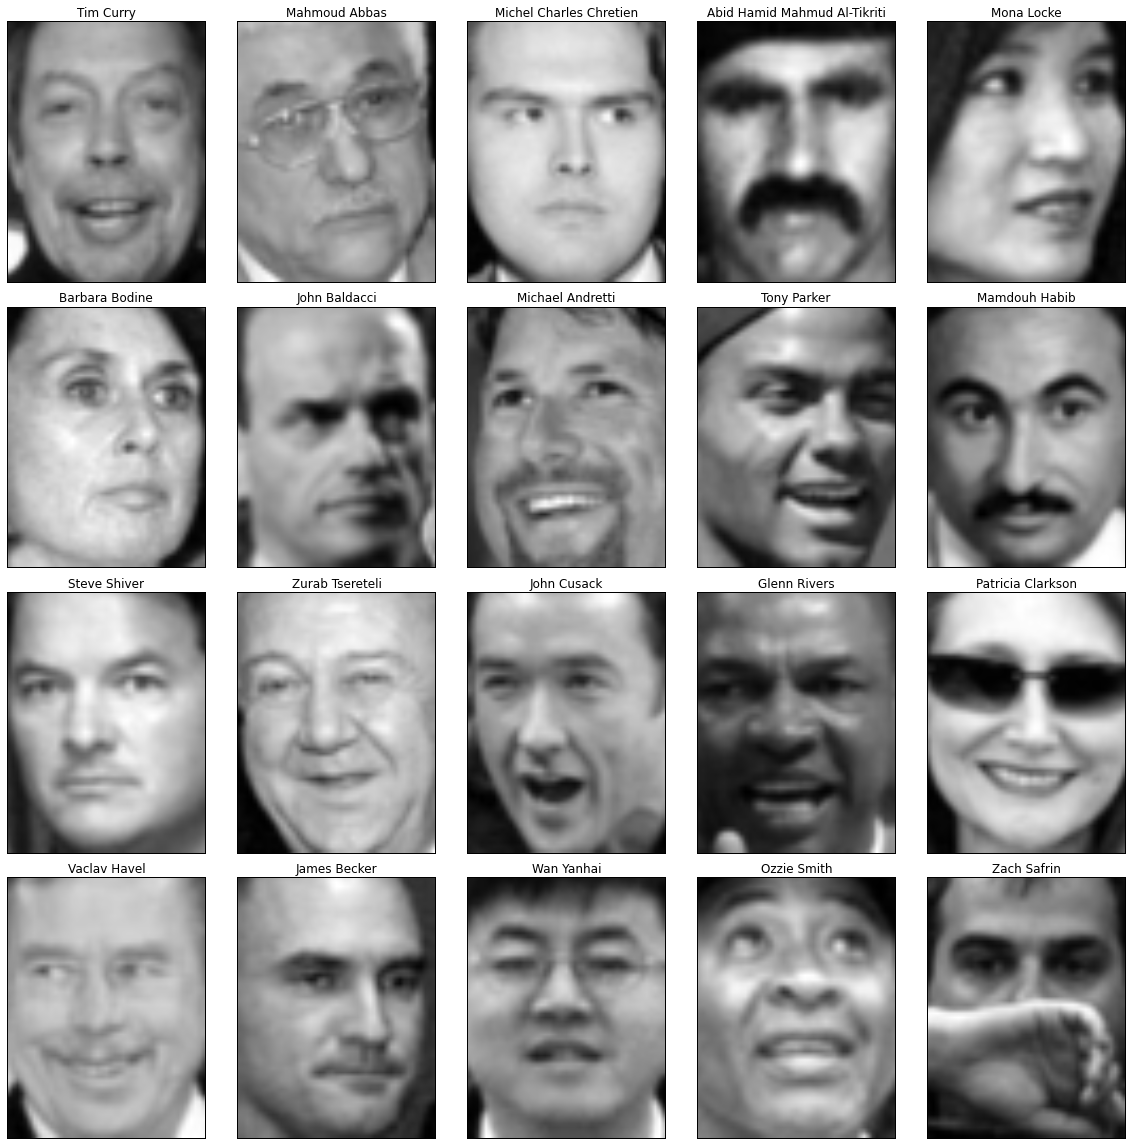

In [1]:
from sklearn import datasets

data = datasets.fetch_lfw_people()  # pri prvnim spusteni tahle radka stahne dataset z internetu, muze to chvili trvat

%matplotlib inline
import matplotlib.pyplot as plt

def plot_img(ax, img, title=''):    # jednoducha utilitka na nakresleni obrazku do os grafu
    ax.imshow(img, cmap=plt.cm.gray)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(title)

plt.figure(figsize=(16,16))         # nakreslime prvnich 20 obliceju
for i in range(20):
    ax = plt.subplot(4, 5 ,i+1)
    plot_img(ax, data.data[i].reshape((62,47)), data.target_names[data.target[i]])
    
plt.tight_layout()

Zkusme nyní na obrázky aplikovat PCA analýzu a podívat se, jak vypadají hlavní komponenty (tj. vlastní vektory s největšími vlastními čísly). Je dobré si uvědomit, že vlastní vektory v tomhle případě jsou opět obrázky obličejů. Tvoří vlastně nějakou menší bázi původního prostoru. Díky tomu si můžeme namalovat jak ty vektory vypadají.

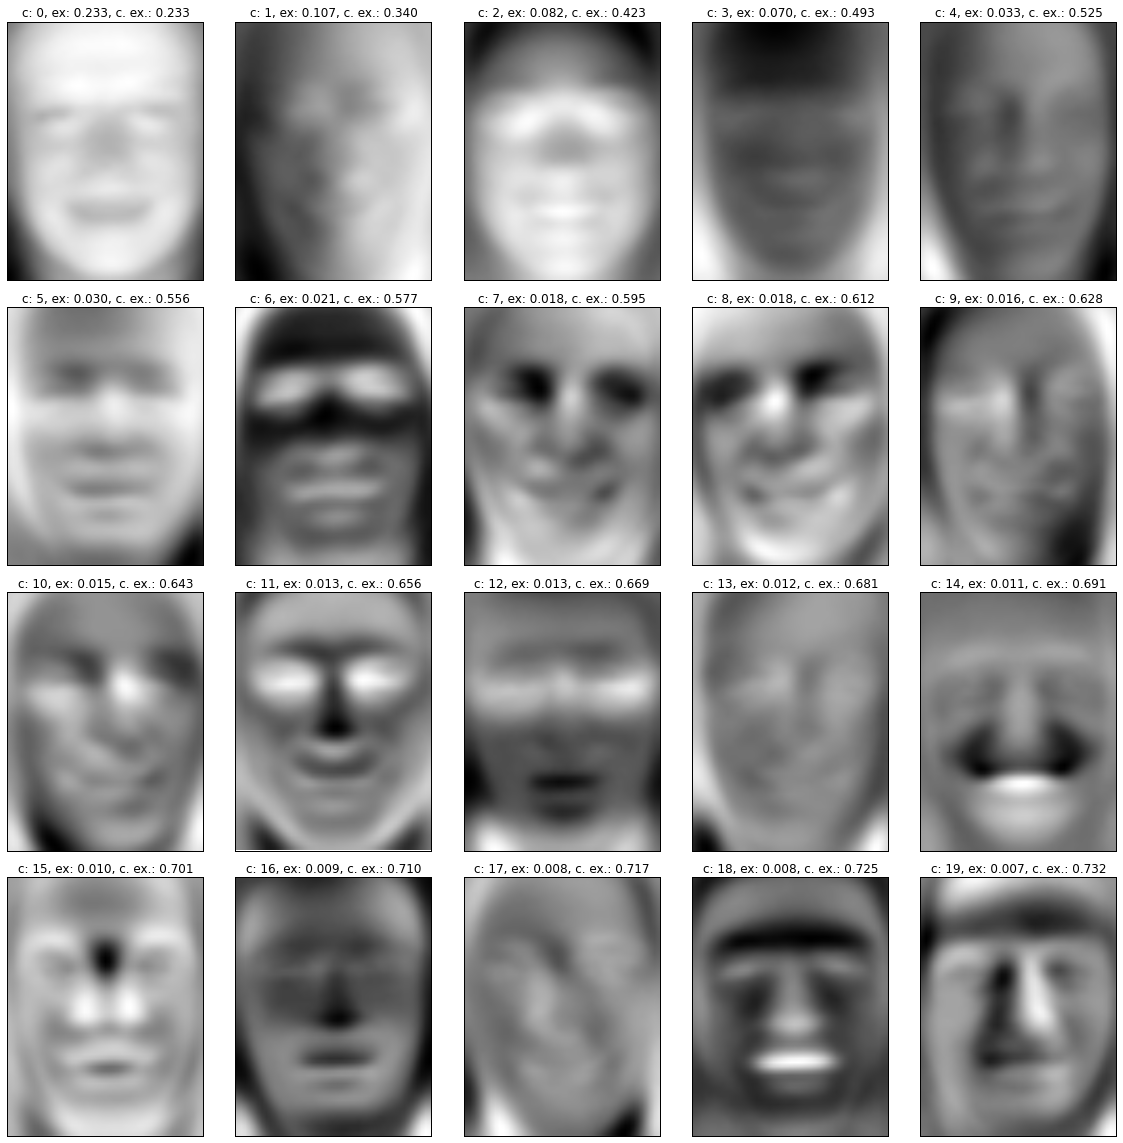

In [3]:
from sklearn import decomposition

pca = decomposition.PCA()
pca.fit(data.data)       # natrenujeme PCA analyzu

plt.figure(figsize=(16,16)) # zobrazime 20 nejdulezitejsich komponent
for i in range(20):
    ax = plt.subplot(4, 5 ,i+1)
    title = 'c: %d, ex: %.3f, c. ex.: %.3f' % (i, pca.explained_variance_ratio_[i], sum(pca.explained_variance_ratio_[:i+1]))
    plot_img(ax, pca.components_[i].reshape((62,47)), title)

plt.tight_layout()

Když následně provedeme transformaci nějakého obrázku pomocí PCA analýzy (tj. právě to zobrazení do prostoru s menší dimenzí), tak vlastně hledáme koeficienty lineární kombinace těchto komponent, které se podobobají vstupnímu obrázku (hledáme průmět tohoto obrázku na podprostor daný těmi kompotentami). 

Zkusme tedy transformovat nějaký obrázek a podívat se na koeficienty, které dostane. Zajímavější potom je se podívat, jak moc se promátnutý obrázek podobá oroginálu. To si nakreslíme pro různé počty hlavních komponent.

transformace:  [[  284.23748779 -1427.65478516  -894.53839111   371.03015137
    149.85940552    62.43022156  -397.24032593    44.70915222
    374.52178955   366.27868652]]


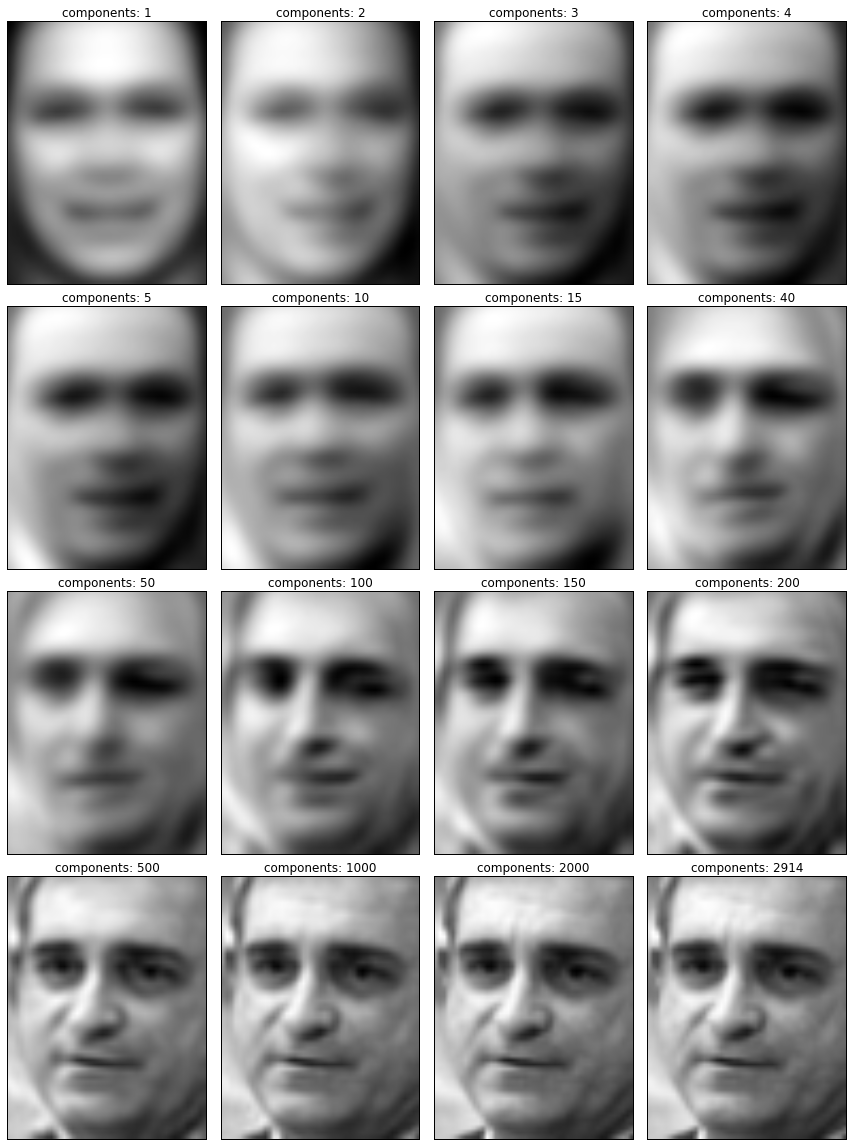

In [4]:
import numpy as np

face = pca.transform(data.data[322])  # vybereme nejaky obrazek a transformujeme ho pomoci PCA

print('transformace: ', face[:, :10]) # koeficienty nejsou tak zajimave, ale vidime, jak dostat nas obrazek z hlavnich komponent

comp_counts = [1, 2, 3, 4, 5, 10, 15, 40, 50, 100, 150, 200, 500, 1000, 2000, 62*47] # vykreslime rekonstruovany obrazek pro 
plt.figure(figsize=(12,16))                                                          # ruzne pocty komponent
for i, comps in zip(range(len(comp_counts)), comp_counts):    
    ax = plt.subplot(4, 4, i+1)
    img = np.dot(face[:, :comps], pca.components_[:comps, :])+pca.mean_
    plot_img(ax, img.reshape((62,47)), 'components: %d' % comps)
    
plt.tight_layout()

Zkusme pro porovnání ještě tzv. truncated SVD, to je přímo SVD dekompozice, ze které se vezmou jen ty první vlastní vektory. Uvidíme, že výsledky jsou skoro stejné. Jak jsme již zmiňovali, výhodou SVD je to, že umí pracovat s řídkými maticemi a navíc je o něco efektivnější. PCA se naopak hodí, pokud chceme jen několik málo hlavních komponent. Výsledky obou metod jsou velmi podobné.

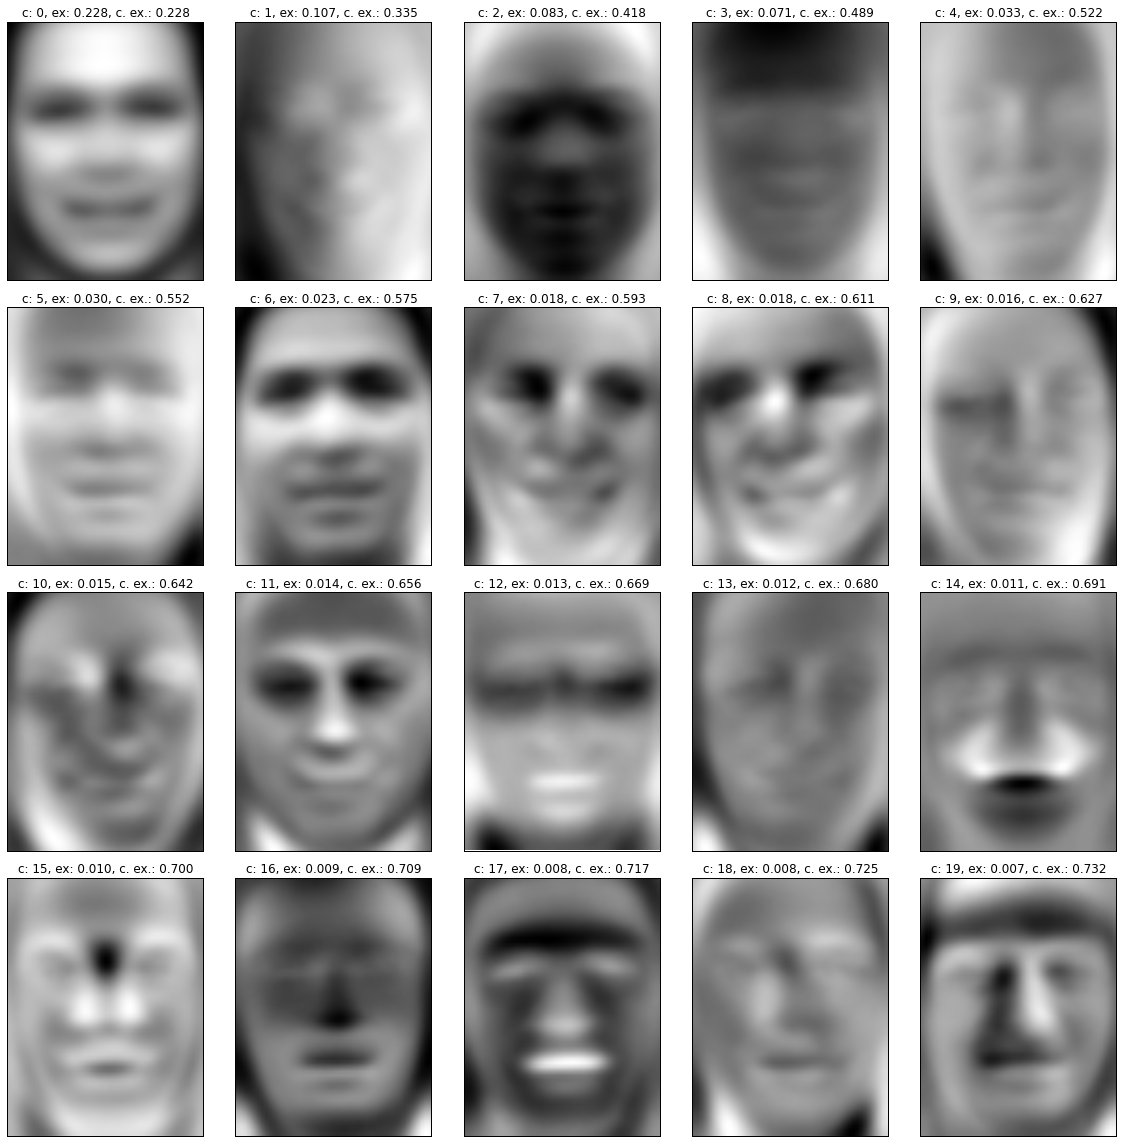

In [5]:
svd = decomposition.TruncatedSVD(n_components=20, algorithm='arpack', n_iter=20)
svd.fit(data.data)

plt.figure(figsize=(16,16))
for i in range(20):
    ax = plt.subplot(4, 5 ,i+1)
    title = 'c: %d, ex: %.3f, c. ex.: %.3f' % (i, svd.explained_variance_ratio_[i], sum(svd.explained_variance_ratio_[:i+1]))
    plot_img(ax, svd.components_[i].reshape((62,47)), title)

plt.tight_layout()

## NMF - Non-negative Matrix Factorization

Další metodou, která se dá použít ke snížení dimenzionality dat je Non-negative Matrix Factorization (NMF). Cílem NMF je aproximovat matici $V$ jako součin dvou matic $W$ a $H$ s případnou chybou $U$, tedy $V$ = $WH + U$. Matice $V$, $W$ a $H$ obsahují jen nezáporná čísla. Motivací samozřejmě je najít matice $W$ a $H$ tak, aby byly menší, než původní matice $V$.

My toho můžeme využít v případě, že naše data jsou nezáporná, dáme je do matice $V$ (řádky jsou instance, sloupce jsou atributy) a zkusíme najít NMF, přitom samozřejmě minimalizujeme chybu rozkladu vyjadřenou v matici $U$ (chyba se často počítá jak Frobeniova norma, tj. odmocnina součtu druhých mocnic všech čísel v matici).

Matice $W$ potom obsahuje hlavní komponenty rozkladu, které se pomocí linearních kombinací (obsažených v matici $H$) skládají na aproximace původních vstupů.

Zkusme NMF zase na našich obrázcích. Natrénujeme ho a zobrazíme komponenty.

C:\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:532: UserWarning: Iteration limit reached during fit. Solving for W exactly.
  warnings.warn("Iteration limit reached during fit. Solving for W exactly.")


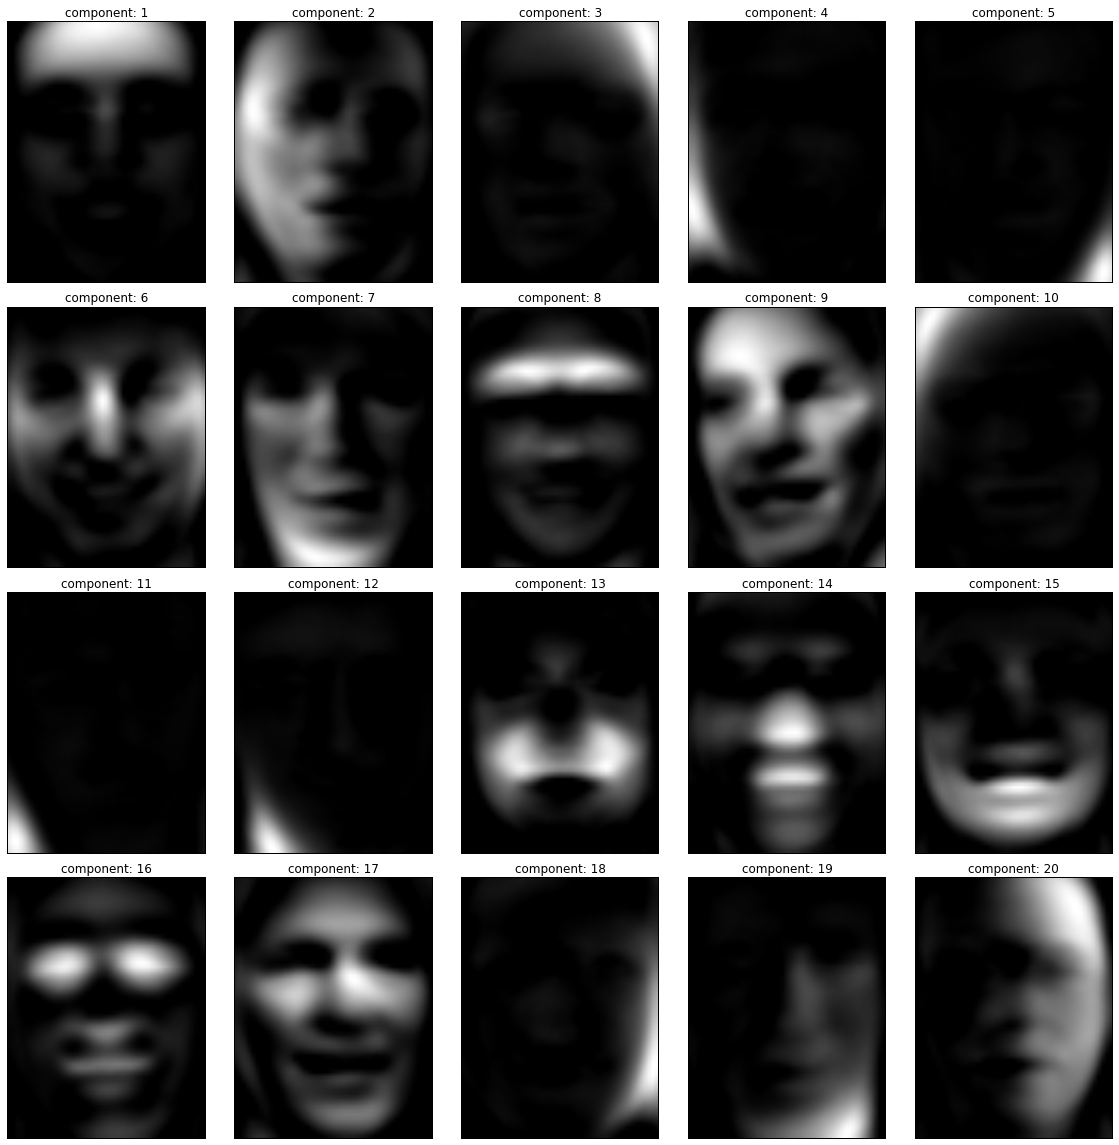

In [162]:
nmf = decomposition.NMF(n_components=20)
nmf.fit(data.data)

plt.figure(figsize=(16,16)) # zobrazime 20 nejdulezitejsich komponent
for i in range(20):
    ax = plt.subplot(4, 5 ,i+1)
    title = 'component: %d' % (i+1)
    plot_img(ax, nmf.components_[i].reshape((62,47)), title)
    
plt.tight_layout()

Můžeme se ještě podívat, jak vypadá aproximace našeho obrázku v závislosti na počtu komponent u NMF. Výpočet jsem po cca 8 hodiných zabil, proto nejsou obrázky všechny. 

C:\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:532: UserWarning: Iteration limit reached during fit. Solving for W exactly.
  warnings.warn("Iteration limit reached during fit. Solving for W exactly.")
C:\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:252: UserWarning: Iteration limit reached in nls subproblem.
  warnings.warn("Iteration limit reached in nls subproblem.")


KeyboardInterrupt: 

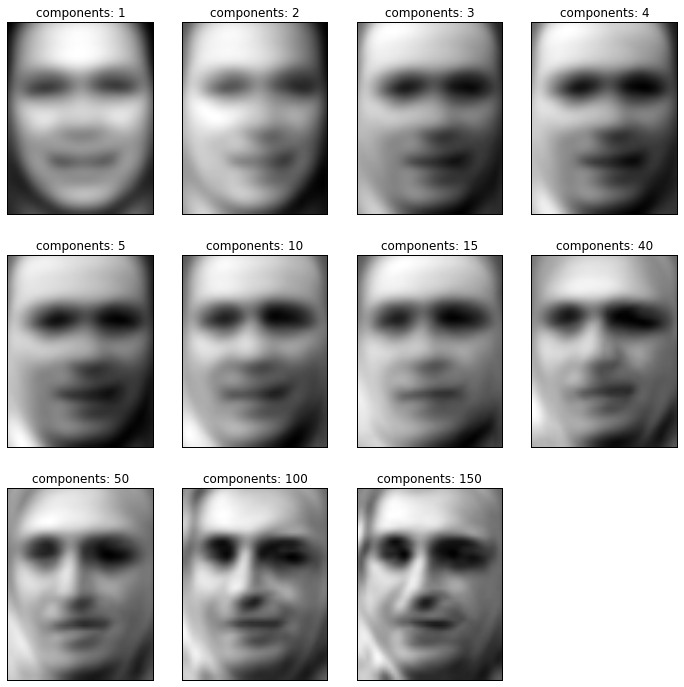

In [6]:
comp_counts = [1, 2, 3, 4, 5, 10, 15, 40, 50, 100, 150, 200, 500, 1000, 2000, 62*47] # vykreslime rekonstruovany obrazek pro 
plt.figure(figsize=(12,16))                                                          # ruzne pocty komponent
for i, comps in zip(range(len(comp_counts)), comp_counts):
    nmf = decomposition.NMF(n_components=comps)
    nmf.fit(data.data)
    face = nmf.transform(data.data[322])  # vybereme nejaky obrazek a transformujeme ho pomoci NMF
    ax = plt.subplot(4, 4, i+1)
    img = np.dot(face, nmf.components_)
    plot_img(ax, img.reshape((62,47)), 'components: %d' % comps)

plt.tight_layout()

## ICA - Independent Component Analysis

Independent Component Analysis (ICA) narozdíl od předcházejích dvou metod hledá komponenty,  které jsou navzájem nezávislé. ICA byla původně používána v oblasti zpracování signálu, ale dá se použít i obecně. Při zpracování signálu má velmi dobré výsledky a umí z lineární kombinace signalů vytáthnout jeho hlavní složky. Můžeme si to představit třeba tak, že signál je součet několika sinusovek, ICA umí často najít původní sinusovky, ze kterých se signál skládá. My opět zkusíme tuto metodu aplikovat náš dataset a podíváme se na výsledky.

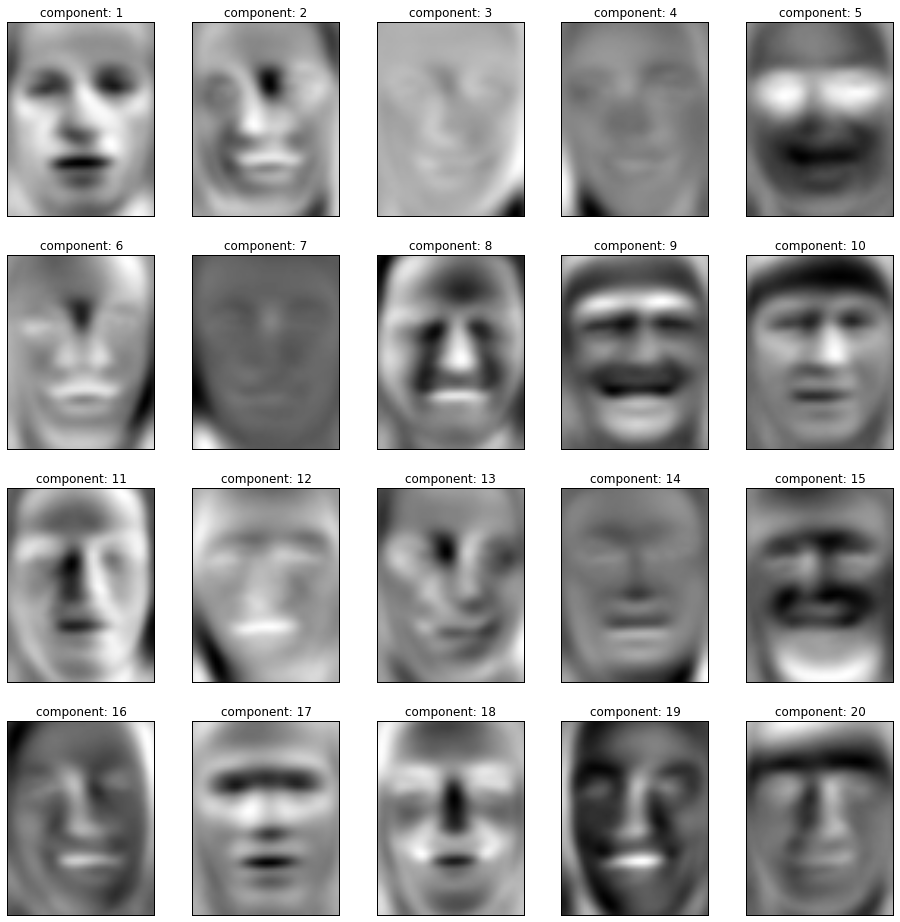

In [7]:
ica = decomposition.FastICA(n_components=20)
ica.fit(data.data)

plt.figure(figsize=(16,16)) # zobrazime 20 nejdulezitejsich komponent
for i in range(20):
    ax = plt.subplot(4, 5 ,i+1)
    title = 'component: %d' % (i+1)
    plot_img(ax, ica.components_[i].reshape((62,47)), title)

## k-Means

Algoritmus $k$-Means je docela známý, jedna se primárně o shlukovací algoritmus, ale dá se použít i k reduci dat. Toho se dá docálit tím, že se jednotlivé instance vyjádří jako vzdálenosti od středů jednotlivých shluků. Zvolený počet shluků potom ovlivňuje konečnou dimenzionalitu prostoru. Zkusme to zase s 20 na našich datech.

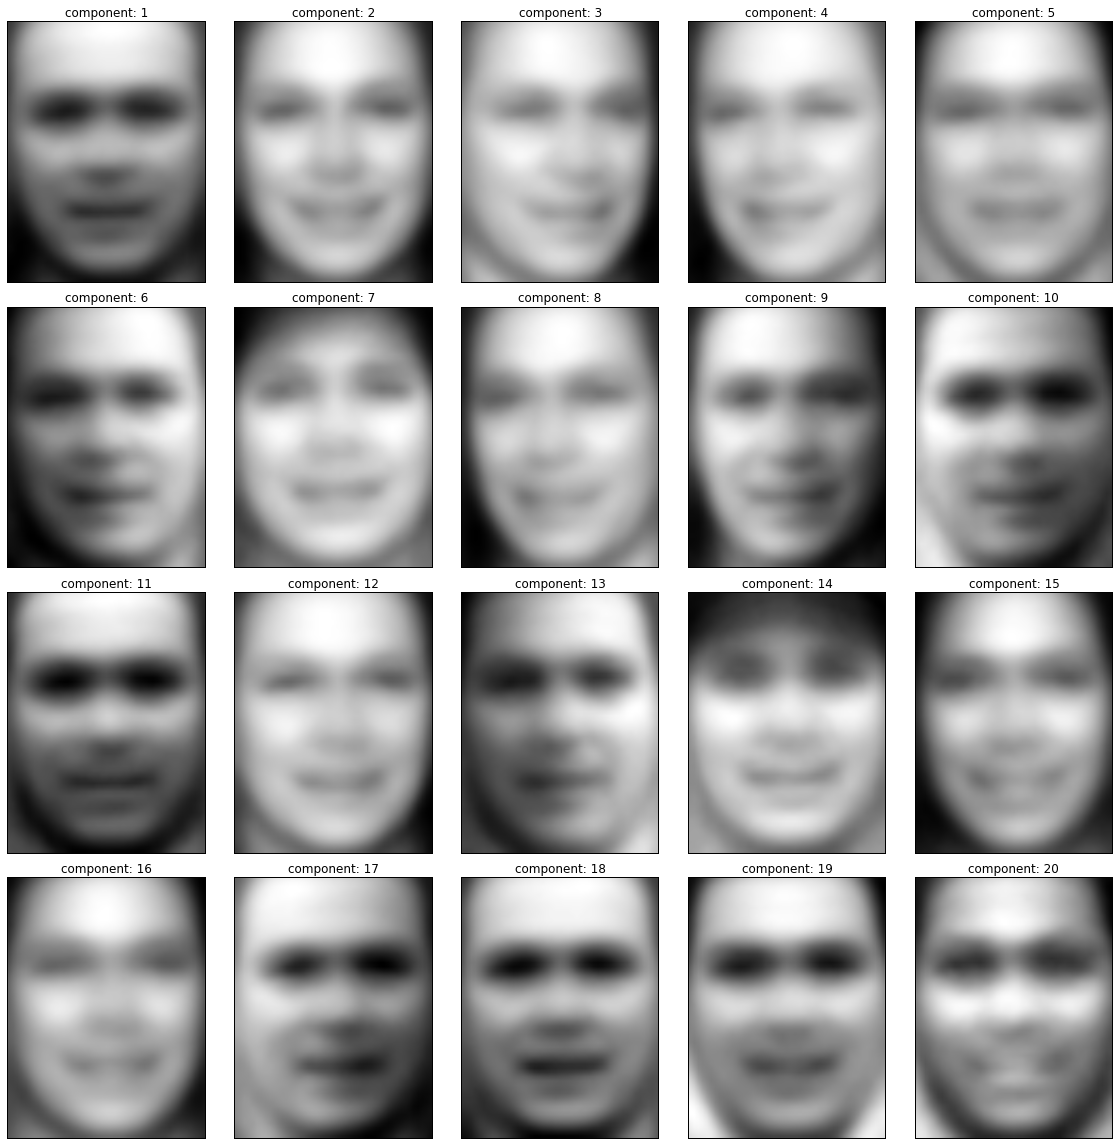

In [10]:
from sklearn import cluster

kmeans = cluster.KMeans(n_clusters=20)
kmeans.fit(data.data)

plt.figure(figsize=(16,16)) # zobrazime 20 nejdulezitejsich komponent
for i in range(20):
    ax = plt.subplot(4, 5 ,i+1)
    title = 'component: %d' % (i+1)
    plot_img(ax, kmeans.cluster_centers_[i].reshape((62,47)), title)
    
plt.tight_layout()

## t-SNE (t-distributed stochastic neighbor embedding)

Hned na první hodině jsme se zmiňovali o metodě t-SNE. Ta je vhodná jen pro vizualizaci dat a nedá se přímo použít ke snížení dimenze v případě, že bysme s ní chtěli zobrazovat předem neznámá data. Pokud je i testovací množina předem známa, použít ji lze. Hlavním důvodem pro tuto nevýhodu je, že t-SNE optimalizuje přímo rozložení bodů v prostoru s nižší dimenzí, nehledá tedy zobrazení, které by se dalo obecně použít.

Metoda t-SNE napřed definuje vzdálenost mezi body v mnohodimenzionálním prostoru a potom se snaží najít rozložení bodů v prostoru s nižší dimenzí, které minimalizuje tzv. Kullback-Leibler divergenci, to je míra podobnosti dvou pravděpodobnostních distribucí. Konkrétně, vzdálenost $p_{ij}$ dvou instancí $x_i$ a $x_j$ v mnohodimenzionálním prostoru se počítá jako 

$$p_{j|i} = \frac{\exp(-\lVert\mathbf{x}_i - \mathbf{x}_j\rVert^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-\lVert\mathbf{x}_i - \mathbf{x}_k\rVert^2 / 2\sigma_i^2)},$$
$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}.$$

Následně t-SNE hledá rozložení bodů $y_i = f(x_i)$, u kterých zase spočítá jejich podobnost $q_{ij}$ obdobně jako výše (ale místo Gaussianů se používá Studentovo t-rozdělení) $$q_{ij} = \frac{(1 + \lVert \mathbf{y}_i - \mathbf{y}_j\rVert^2)^{-1}}{\sum_{k \neq l} (1 + \lVert \mathbf{y}_k - \mathbf{y}_l\rVert^2)^{-1}}.$$ Při hledání vhodného rozložení bodů se optimalizuje Kullback-Leibler divergence těchto dvou distribucí $$KL(P||Q) = \sum_{i \neq j} p_{ij} \, \log \frac{p_{ij}}{q_{ij}}$$

t-SNE si ukážeme až za chvíli, až budeme zkoušet zobrazit data do dvou dimenzí.

## Porovnání jednotlivých metod

Podívejme se ještě jednou na pět nejdůležitějších komponent tak, jak je najdou výše uvedené metody. Abysme mohli nakonec ještě porovnat, jakým způsobem metody zobrazují data do 2D prostoru, vezmeme si menší data, konkrétně z našeho datasetu vybereme jen obličeje lidí, kteří jsou v něm alespoň osmdesátkrát. Dostaneme 1 140 obrázků pěti různých lidí.

In [27]:
small_data = datasets.fetch_lfw_people(min_faces_per_person=70)
print('Počet instancí: %d' % small_data.data.shape[0])
print('Počet tříd: %d' % len(small_data.target_names))
print('Jména: %s' % list(small_data.target_names))

Počet instancí: 1288
Počet tříd: 7
Jména: ['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair']


 Zobrazme si teď pět nejdůležitějších komponent nalezených jednotlivýma metodama na našich menších datech.

In [39]:
clfs = [decomposition.PCA(n_components=5), 
        decomposition.TruncatedSVD(n_components=5, algorithm='randomized'),
        decomposition.TruncatedSVD(n_components=5, algorithm='arpack'),
        decomposition.NMF(n_components=5), 
        decomposition.FastICA(n_components=5), 
        cluster.KMeans(n_clusters=5)]

names = ['PCA', 'tSVD-rand', 'tSVD-arpack', 'NMF', 'ICA', 'k-means']

clfs = [clf.fit(small_data.data) for clf in clfs] # natrenujeme vsechny metody

C:\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:532: UserWarning: Iteration limit reached during fit. Solving for W exactly.
  warnings.warn("Iteration limit reached during fit. Solving for W exactly.")


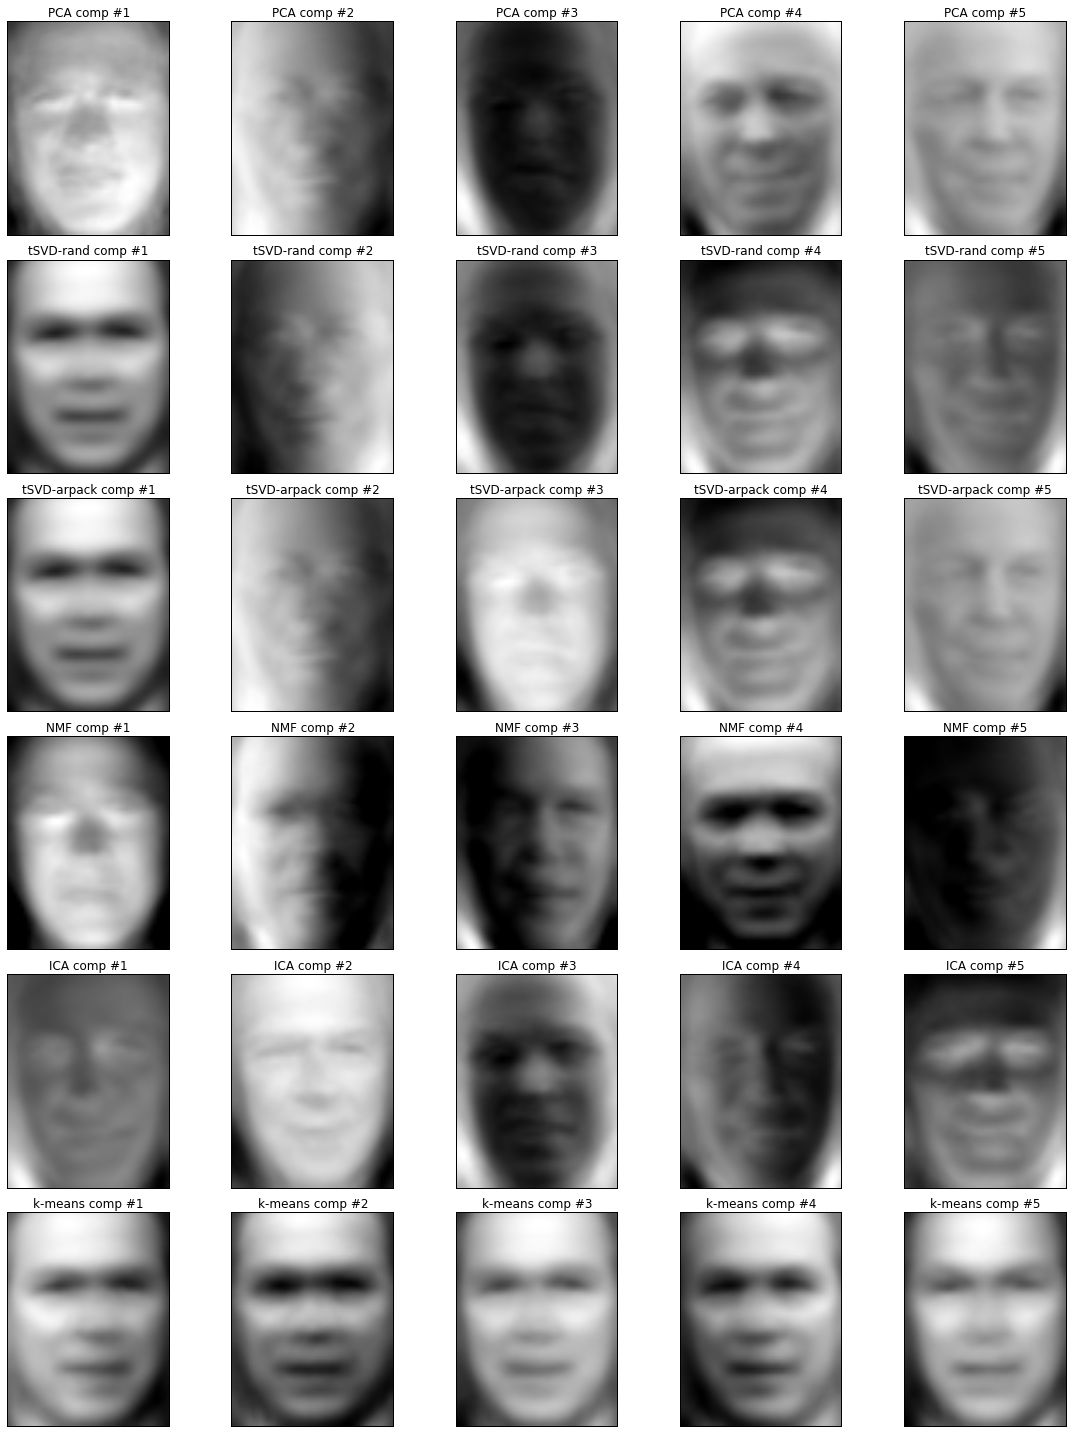

In [40]:
plt.figure(figsize=(16,20)) # zobrazime 20 nejdulezitejsich komponent
for j in range(5):          # pro kazdou metodu krome k-means
    for i in range(5):
        ax = plt.subplot(6, 5 , 5*j+i+1)
        title = '%s comp #%d' % (names[j], i+1)
        plot_img(ax, clfs[j].components_[i].reshape((62,47)), title)

for i in range(5):
    ax = plt.subplot(6, 5 , 25+i+1)
    title = '%s comp #%d' % (names[5], i+1)
    plot_img(ax, clfs[5].cluster_centers_[i].reshape((62,47)), title)

plt.tight_layout()

A nakonec zkusme ještě zobrazit obrázky do 2D a 3D prostoru, jestli uvidíme, že se dají nějak oddělit od sebe. Zkusíme zase všechny metody a navíc přidáme t-SNE. Je třeba si uvědomit, že při zobrazení do 2D (i 3D) libovolnou metodou přicházíme o více než 99% dat, která jsou v obrázcích obsažena, takže nemůžeme čekat skvělé výsledky.

C:\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:532: UserWarning: Iteration limit reached during fit. Solving for W exactly.
  warnings.warn("Iteration limit reached during fit. Solving for W exactly.")


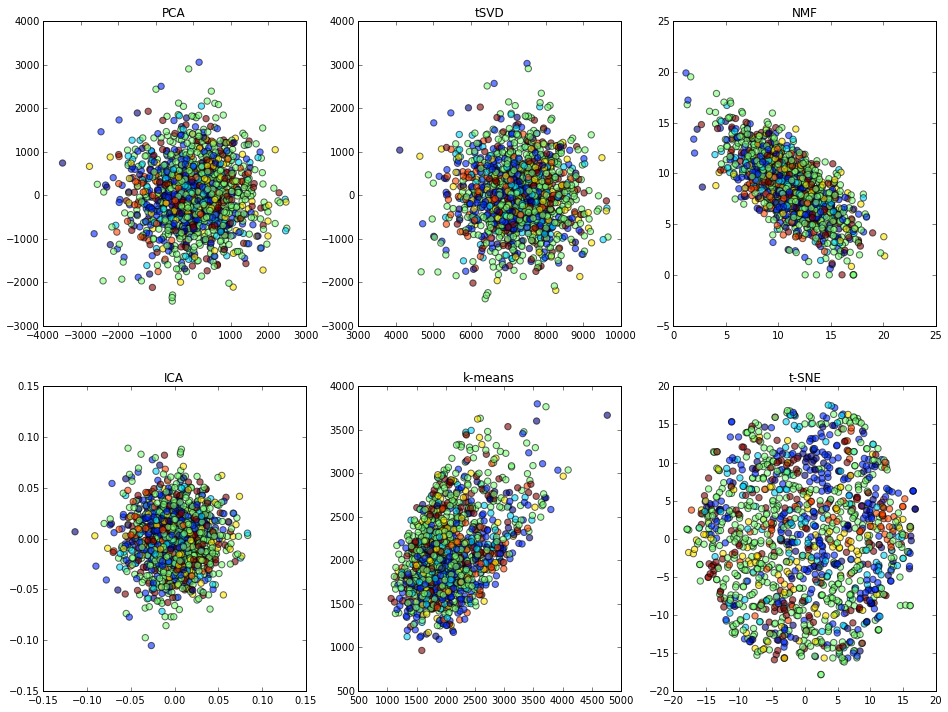

In [53]:
from sklearn import manifold

clfs = [decomposition.PCA(n_components=2), 
        decomposition.TruncatedSVD(n_components=2, algorithm='arpack'),
        decomposition.NMF(n_components=2), 
        decomposition.FastICA(n_components=2), 
        cluster.KMeans(n_clusters=2),
        manifold.TSNE(n_components=2)]

names = ['PCA', 'tSVD', 'NMF', 'ICA', 'k-means', 't-SNE']

trans = [clf.fit_transform(small_data.data) for clf in clfs]

from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()
colors = lbl.fit_transform(small_data.target)

plt.figure(figsize=(16, 12))
for tr, name, i in zip(trans, names, range(6)):
    plt.subplot(2, 3, i+1)
    plt.scatter(tr[:, 0], tr[:, 1], c=colors, s=40, alpha=0.6)
    plt.title(name)

C:\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:532: UserWarning: Iteration limit reached during fit. Solving for W exactly.
  warnings.warn("Iteration limit reached during fit. Solving for W exactly.")


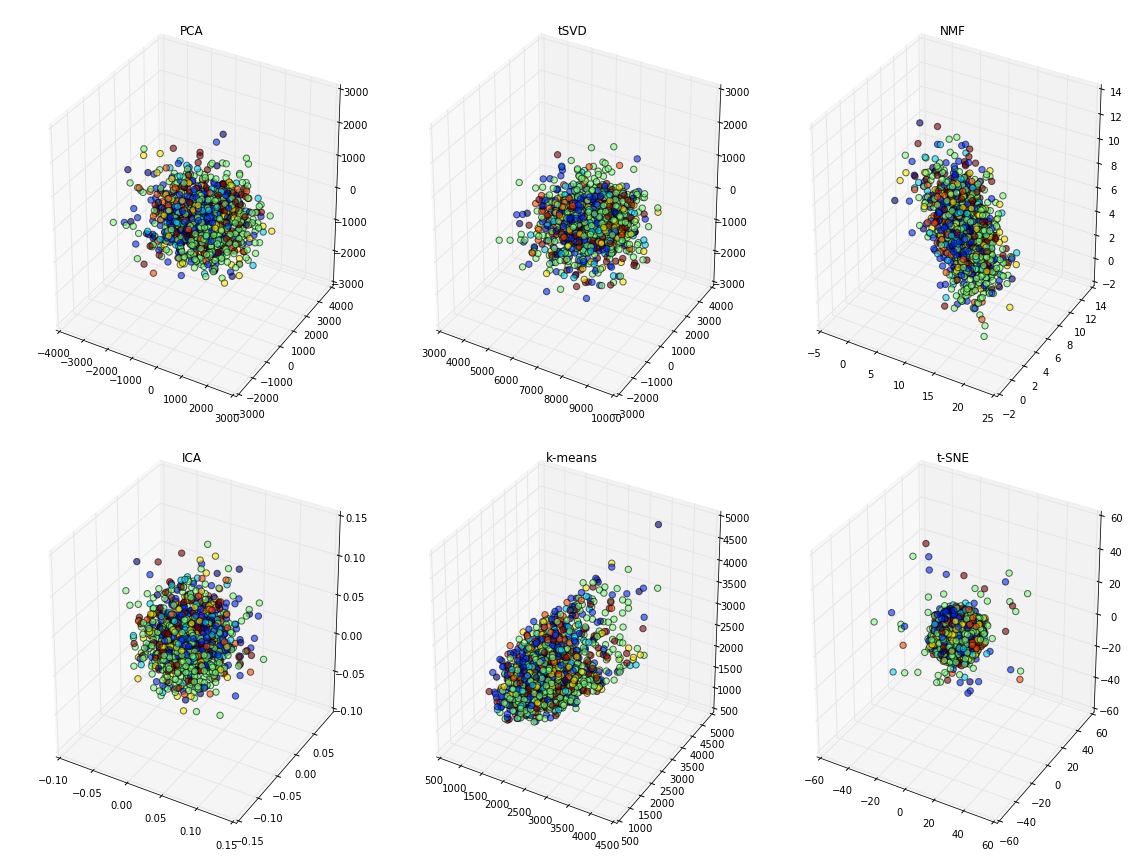

In [52]:
clfs = [decomposition.PCA(n_components=3), 
        decomposition.TruncatedSVD(n_components=3, algorithm='arpack'),
        decomposition.NMF(n_components=3), 
        decomposition.FastICA(n_components=3), 
        cluster.KMeans(n_clusters=3),
        manifold.TSNE(n_components=3)]

names = ['PCA', 'tSVD', 'NMF', 'ICA', 'k-means', 't-SNE']

trans = [clf.fit_transform(small_data.data) for clf in clfs]

from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D

lbl = preprocessing.LabelEncoder()
colors = lbl.fit_transform(small_data.target)

fig = plt.figure(figsize=(16, 12))
for tr, name, i in zip(trans, names, range(6)):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    ax.scatter(tr[:, 0], tr[:, 1], tr[:, 2], c=colors, s=40, alpha=0.6)
    ax.set_title(name)

plt.tight_layout()